In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold

np.random.seed(1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Gaps over the years

In a [previous kernel][1] I measure the SHSAT applicants gap that happened in 2017. This quantity is an estimate of the amount of applicants that took the SHSAT less than what we expect.

In this kernel, I will take a step further and try to understand how the gap evolves from year to year. In the process of doing so, we may get the answer to the following question (and some other exciting things):

"Is the estimated gap for 2017 still relevant when we talk about 2018?"

[1]: https://www.kaggle.com/araraonline/measuring-the-applicants-gap-in-2017

# Calculating the gap of applicants

## Data used

The data used in this kernel is quite different from the last one. Basically, we are targeting schools from Central Harlem, this region in New York:

![](../data/keep/map-harlem.png)

Characteristics:

- Comprehends 21 schools from Central Harlem in 2015 and 2016
- Contains the demographics, NYS test results and SHSAT statistics for each year for each school
- Was made as a mix between a dataset handed out by PASSNYC and datasets found in the NYC site

## Model

We use the full model generated by the [first kernel][1] to generate first predictions. These predictions, then, are fed into another model to account for yearly influences (the amount  of SHSAT applicants in the city oscillates from year to year).

[1]: https://www.kaggle.com/araraonline/measuring-the-applicants-gap-in-2017

In [2]:
# load dataframe
df = pd.read_pickle('../data/process/d5_full.pkl')
df = df[df.notnull().all(axis=1)]
nschools = df.reset_index()['DBN'].nunique()
print("loaded {} schools".format(nschools))

df.head()

loaded 21 schools


School Name  Percent Asian  Percent Black  \
DBN    Year                                                           
05M046 2015    P.S. 046 Arthur Tappan          0.009          0.506   
       2016    P.S. 046 Arthur Tappan          0.007          0.499   
05M123 2015  P.S. 123 Mahalia Jackson          0.013          0.546   
       2016  P.S. 123 Mahalia Jackson          0.015          0.517   
05M129 2015   P.S. 129 John H. Finley          0.018          0.418   

             Percent Hispanic  Percent White  Percent Other  \
DBN    Year                                                   
05M046 2015             0.465          0.010          0.010   
       2016             0.475          0.010          0.009   
05M123 2015             0.392          0.032          0.017   
       2016             0.412          0.040          0.016   
05M129 2015             0.511          0.022          0.031   

             Percent English Language Learners  \
DBN    Year                                      
05M046 2015                              0.108   
       2016                              0.091   
05M123 2015                              0.188   
       2016                              0.185   
05M129 2015                              0.126   

             Percent Students with Disabilities  \
DBN    Year                                       
05M046 2015                               0.261   
       2016                               0.280   
05M123 2015                               0.262   
       2016                               0.260   
05M129 2015                               0.215   

             Percent of Students Chronically Absent  Economic Need Index  \
DBN    Year                                                                
05M046 2015                                   0.394                0.903   
       2016                                   0.409                0.909   
05M123 2015                                   0.494                0.835   
       2016                                   0.362                0.868   
05M129 2015                                   0.329                0.854   

             Charter School?  Number Tested - ELA  Mean Scale Score - ELA  \
DBN    Year                                                                 
05M046 2015              0.0                 66.0               -1.380656   
       2016              0.0                 58.0               -1.103425   
05M123 2015              0.0                 48.0               -1.999821   
       2016              0.0                 53.0               -0.909242   
05M129 2015              0.0                 53.0               -1.005304   

             # Level 1 - ELA  % Level 1 - ELA  # Level 2 - ELA  \
DBN    Year                                                      
05M046 2015             41.0         62.12121             16.0   
       2016             39.0         67.24138             14.0   
05M123 2015             36.0         75.00000             10.0   
       2016             24.0         45.28302             22.0   
05M129 2015             32.0         60.37736             15.0   

             % Level 2 - ELA  # Level 3 - ELA  % Level 3 - ELA  \
DBN    Year                                                      
05M046 2015         0.242424              9.0         0.136364   
       2016         0.241379              2.0         0.034483   
05M123 2015         0.208333              2.0         0.041667   
       2016         0.415094              7.0         0.132075   
05M129 2015         0.283019              5.0         0.094340   

             # Level 4 - ELA  % Level 4 - ELA  # Level 3+4 - ELA  \
DBN    Year                                                        
05M046 2015              0.0         0.000000                9.0   
       2016              3.0         0.051724                5.0   
05M123 2015              0.0         0.000000                2.0   
       2016              0.0         0

In [3]:
# load model
with open('../data/output/full_model.pkl', mode='rb') as f:
    model = pickle.load(f)
print("loaded model")

loaded model


In [4]:
def get_inputs(df):
    base_df = df[[  # explanatory variables
        'Charter School?',
        'Percent Asian',
        'Percent Black',
        'Percent Hispanic',
        'Percent Other',
        'Percent English Language Learners',
        'Percent Students with Disabilities',
        'Economic Need Index',
        'Percent of Students Chronically Absent',
        
        'Mean Scale Score - ELA',
        '% Level 2 - ELA',
        '% Level 3 - ELA',
        '% Level 4 - ELA',
        'Mean Scale Score - Math',
        '% Level 2 - Math',
        '% Level 3 - Math',
        '% Level 4 - Math',
    ]]

    # transform the variables (apply the PCA)
    n_components = 8
    pca = PCA(n_components)
    transformed = pca.fit_transform(base_df)
    transformed = pd.DataFrame(transformed, index=base_df.index, columns=["PC{}".format(i+1) for i in range(n_components)])

    # add a constant column (needed for our model with statsmodels)
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)

    return inputs


def get_outputs(df):
    outputs = logit(df['% SHSAT Testers'])
    return outputs

inputs = get_inputs(df)
outputs = get_outputs(df)

In [5]:
# first model

results = model.fit()  # full model
predictions = model.predict(results.params, exog=inputs)
predictions = pd.Series(predictions, index=df.index, name='% SHSAT Testers')

In [6]:
# second model

years = df.reset_index()['Year']
years.index = df.index

inputs2 = pd.DataFrame(index=df.index)
inputs2['constant'] = 1.0
inputs2['year_2015'] = (years == 2015).astype(int)
inputs2['prediction'] = predictions

model2 = sm.RLM(outputs, inputs2)
results2 = model2.fit()
predictions2 = results2.fittedvalues

Here are some statistics for the model fitted:

In [7]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                   40
Model:                            RLM   Df Residuals:                       37
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 08 Aug 2018                                         
Time:                        00:37:14                                         
No. Iterations:                    13                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -1.3162      0.163     -8.062      0.000      -1.636      -0.996
year_2015      0.1866      0.197      0.948      0.343      -0.199       0.572
prediction     0.4282      0.109      3.933      0.000       0.215       0.642
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

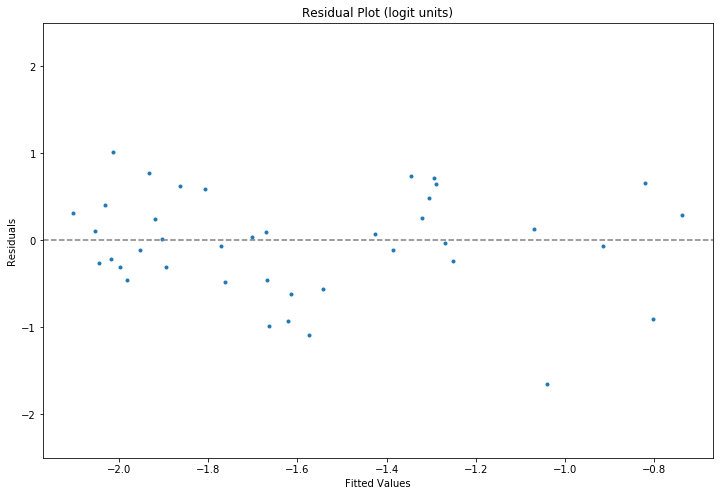

In [8]:
_predictions = predictions2
_actual = outputs

xs = _predictions
ys = _actual - _predictions  # residual

plt.figure(figsize=(12, 8))
plt.plot(xs, ys, '.')
plt.axhline(0.0, linestyle='--', color='gray')
plt.ylim(-2.5, 2.5)
plt.title("Residual Plot (logit units)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals");

In [9]:
mae = median_absolute_error(_actual, _predictions)
mse = mean_squared_error(_actual, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.35977207805200273
Mean Squared Error: 0.33402285295366857


And a predicted percentage vs actual percentage graph for non-statistic folks:

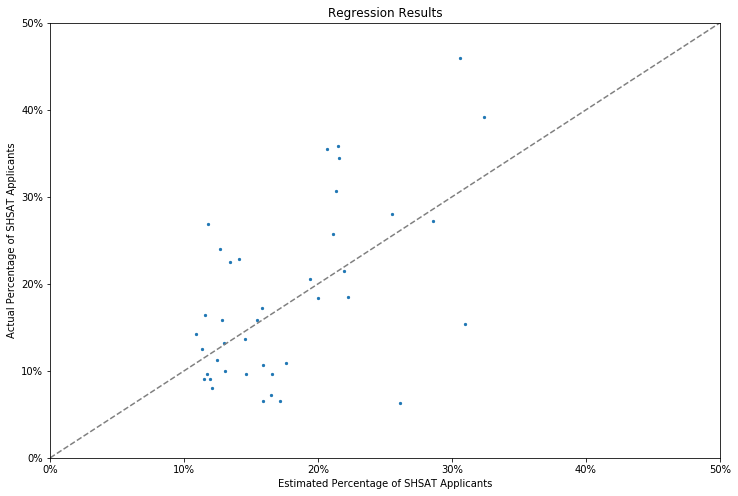

In [10]:
xs = expit(_predictions)
ys = expit(_actual)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(xs, ys, s=5)
ax.plot([0, 1], [0, 1], '--', c='gray')
ax.xaxis.set_major_formatter(plt.FuncFormatter("{:.0%}".format))
ax.yaxis.set_major_formatter(plt.FuncFormatter("{:.0%}".format))
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)
ax.set_title("Regression Results")
ax.set_xlabel("Estimated Percentage of SHSAT Applicants")
ax.set_ylabel("Actual Percentage of SHSAT Applicants");

# Comparing what happened from one year to another

Well, we need a way to compare gaps from one year to the other. :)

To do so, I will assume the gap in each school follows a certain formula:

$G_y = w \cdot G_{y-1} + (1 - w) \cdot B + \epsilon$

Where:

- $G_y$ is the gap in year y
- $B$ is a baseline gap of the school (what we usually expect of it)
- $w$ is a weight used to balance the  past year gap and the baseline gap
- $\epsilon$ is an error term and denotes something we can't measure<sup>1</sup>

Ideally, we would want to know B. B can indicate a range of factors, like a school not having enough incentive for SHSAT, a trend of underconfidence among students, a good exposure of SHSAT in a school, etc.

Sadly, we can't know the exact value of B. So, we must estimate it. And the only estimate we have is the actual value for the gap that happened in 2017.

Substituting $B$ with $G_{2017}$ in the formula above, it turns up to:

$G_y = G_{y-1} + \epsilon$

<sub>1: The actual meaning of ϵ will be explained by the end of this analysis</sub>

---

Below I will show some plots that will help us analyze the relationship between $G_{2015}$ and $G_{2016}$:

In [11]:
pct_residuals = expit(_actual) - expit(_predictions)
pivoted = pct_residuals.reset_index().pivot(index='DBN', columns='Year', values=0)

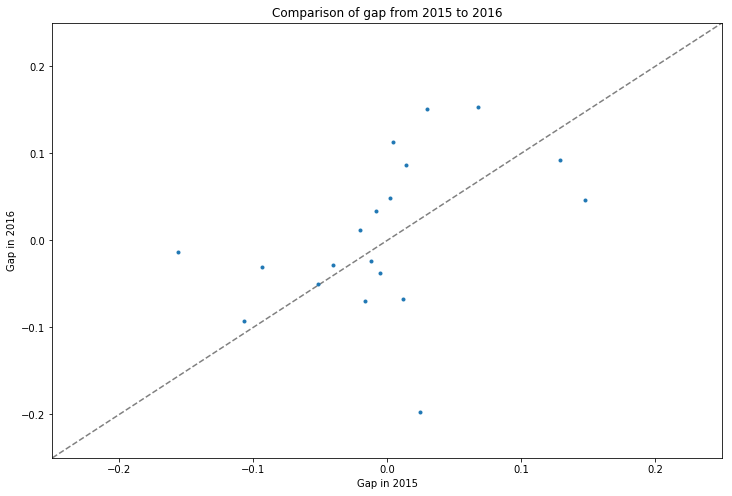

In [12]:
y1 = 2015
y2 = 2016

diffs = (pivoted[y2] - pivoted[y1]).dropna()
mean = diffs.mean()
std = diffs.std()

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot([-0.25, 0.25], [-0.25, 0.25], '--', color='gray')
ax1.plot(pivoted[y1], pivoted[y2], '.')
ax1.set_xlabel("Gap in %s" % y1)
ax1.set_ylabel("Gap in %s" % y2)
ax1.set_xlim(-0.25, 0.25)
ax1.set_ylim(-0.25, 0.25)
ax1.set_title("Comparison of gap from 2015 to 2016");

/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


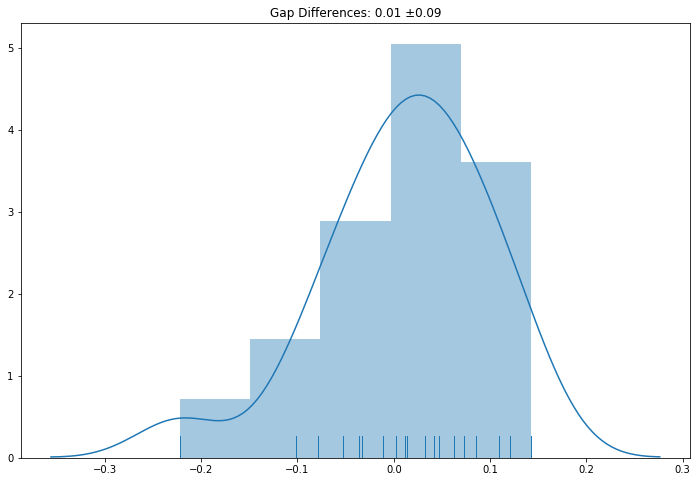

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 8))

sns.distplot(diffs, ax=ax1, rug=True)
ax1.set_title("Gap Differences: {:.2f} ±{:.2f}".format(mean, std));

The first plot compares the gaps measured in 2015 to the gaps measured in 2016. We would expect them to be the same if all the points were over the dashed line. But they aren't! The visible reasons are:

- There is a lot of noise in the gaps from one year to the other
- There is a trend of gaps taking bigger values in 2016, compared to 2015
- There is also an outlier in our data (point to the lower-right corner)

These reasons are better visible in the second plot (distribution of errors). It's got a mean of 2%, indicating upwards trend, while keeping a shape that looks gaussian and standard deviation of 8%.

This standard deviation is *really* important and shows a limitation of the model. But more than this, I think it shows a limitation of *any* model that we could fit here.

Let's give for example a shcool that had a gap of 11% in 2015. In 2016, we expect the gap will still be 11%, but there is a lot of uncertainty. It could move to a value like 16% and we should't even care about it. It could move back to 5% and this would still be okay. This indicates there is a lot of uncertainty intrinsic to schools, an uncertainty that we can't predict with the data we have here, and that we wouldn't (probably) be able to predict *even* if we had more data.

# Caring about the error

So, estimating the gap for one year based on the estimate of the previous one is biased by an error amount. This error is composed both of a trend value (that won't interfere in our analysis, as all schools move in this same direction) and a random value. This random value is important and we should take it into account when comparing schools<sup>1</sup>.

For example, if two schools have a difference in gap of only 1 percentual point, they may be deemed the same and you can't know what to expect next year. If this gap is bigger though, like 15%, you can almost be sure that they have a significant difference and that it will matter the following year (and that it matters right now).

<sub>1: If you just want to do something like ranking the schools and later pass them through a manual examination, the error doesn't make much difference. Actually, the rank won't change that much next year (as indicated by the Spearman's Correlation).</sup>

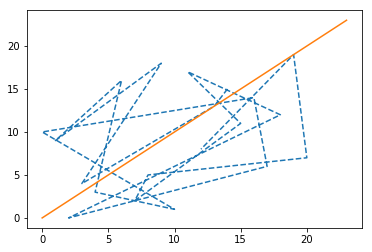

In [31]:
a = np.argsort(pivoted, axis=0).drop('84M341')
plt.plot(a[2015], a[2016], '--')
plt.plot([0, 23], [0, 23], '-')

Are you telling lies?

In [14]:
pivoted.corr(method='spearman')  # can be moved up by removing the outlier

Year,2015,2016
Year,,
2015,1.000000,0.531579
2016,0.531579,1.000000
